# $X^2$ for the Sodium Data
I read through chapter 12 in An Introduction to Error Analysis (Taylor, 2nd ed) that covers $X^2$.  He calls dividing it by the degrees of freedom the reduced $X^2$, or $\tilde{X^2}$.  I used four points, the two from the Cs-137, and two from Co-60 and did a linear regression on that to get a line.  Then 

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [37]:
df = pd.read_csv('data/peaks/uncalibrated_peaks.csv')
df.head()

,detector,element,ROI_Start,ROI_End,Gross,Net,Centroid,FWHM,Known_keV
0,ge,bg,32,35,4093,104,33,--,NaN
1,ge,bg,39,43,21079,12163,40,--,NaN
2,ge,bg,151,154,4259,1189,152,--,NaN
3,ge,bg,165,170,9392,6865,167,2,NaN
4,ge,bg,193,199,23971,-3679,198,--,NaN


In [47]:
# Getting the non-null values for cs137 and co60
na_cal = df[(df['detector']=='na') & (df['Known_keV'].isna() == False)].sort_values(['detector', 'ROI_Start']).copy()
na_cal

,detector,element,ROI_Start,ROI_End,Gross,Net,Centroid,FWHM,Known_keV
39,na,cs137,18,30,10062,7447,22,4,32.0
41,na,cs137,375,454,34939,33578,410,30,661.7
37,na,co60,678,759,8574,6154,713,35,1173.2
38,na,co60,762,859,6822,6282,808,40,1332.5


In [70]:
# Converting FWHM to a number
na_cal['FWHM'] = na_cal['FWHM'].astype(np.float64)
na_cal.dtypes

detector      object
element       object
ROI_Start      int64
ROI_End        int64
Gross          int64
Net            int64
Centroid       int64
FWHM         float64
Known_keV    float64
dtype: object

In [125]:
# Getting the values to fit into a linear model
x = na_cal[['Centroid']]
y = na_cal[['Known_keV']]

In [52]:
# Using scikit-learn to fit a linear regression
model = LinearRegression()
model.fit(x, y)

# Now getting the prediction of the model, using the x as input again
y_hat = model.predict(x)

array([[  27.80056489],
       [ 670.27816451],
       [1172.00680545],
       [1329.31446515]])

In [108]:
# Computing the y-errors, FWHM is 2.355 * sigma, so converting
# it to sigma and then multiplying by two for my error.  So +/- 2 sigma
# is a reasonable error.
na_cal['yerr'] = round(na_cal['FWHM'] / 2.355 * 2, 0)
na_cal

,detector,element,ROI_Start,ROI_End,Gross,Net,Centroid,FWHM,Known_keV,yerr
39,na,cs137,18,30,10062,7447,22,4.0,32.0,3.0
41,na,cs137,375,454,34939,33578,410,30.0,661.7,25.0
37,na,co60,678,759,8574,6154,713,35.0,1173.2,30.0
38,na,co60,762,859,6822,6282,808,40.0,1332.5,34.0


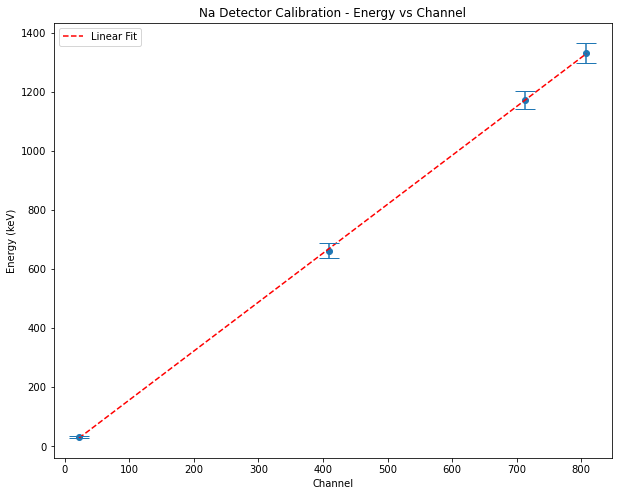

In [126]:
plt.figure(figsize=(10,8))
plt.scatter(x,y)
plt.plot(x, y_hat, linestyle='--', color='r', label='Linear Fit')
plt.errorbar(x.to_numpy(), y.to_numpy(), yerr=na_cal['yerr'], fmt='none', capsize=10)
plt.legend()
plt.title('Na Detector Calibration - Energy vs Channel')
plt.xlabel('Channel')
plt.ylabel('Energy (keV)')
plt.show()

## Computing $\tilde{X}^2$
The reduced $X^2$, which is just $\tilde{X}^2 = \frac{X^2}{N-c}$, where $c$ is the constraints, so $N-c$ is the degrees of freedom.

For this we're doing a linear fit so we have two parameters, slope and intercept, and four points.  So the degrees of freedom is $2$, just $4-2$.

$$\tilde{X}^2 = \frac{1}{N-c}\sum^{N}_{k=1}\left(\frac{O_k - E_k}{\sigma_k}\right)^2$$

Where $O_k$ is the observation, and $E_k$ is the expected value, and of course $\sigma_k$ is the error in the expected value.  In this case $\sigma_k$ is just the FWHM divided by 2.355 to get it as a standard deviation, and then multiplied by 2 so it should be within two standard deviations (95% chance).  The observation is what we measured for the energy, and the expected value is what our linear fit says it should actually be ($\hat{y}$)

In [127]:
# Compute & sum all of these terms
1/2 * (((y.to_numpy() - y_hat)/na_cal[['yerr']].to_numpy())**2).sum()

1.0437843913668485

So I get a $\tilde{X}^2$ of 1.04, basically 1.0 on the nose and this seems like a good fit.